### Análise Exploratória dos Dados Processados e Configuração de Embeddings com FAISS e SentenceTransformers ###

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import faiss

In [4]:
# Caminhos dos arquivos processados

base_dir = r"D:\bases_gen_ai"
train_file = os.path.join(base_dir, "processed", "cleaned_dataset_train.csv")
dev_file = os.path.join(base_dir, "processed", "cleaned_dataset_dev.csv")

In [5]:
# Função para carregar e exibir informações sobre o dataset
def load_and_inspect(file_path):
    print(f"Carregando dados de: {file_path}\n")
    df = pd.read_csv(file_path)
    print("Primeiras linhas do dataset:\n")
    print(df.head())
    print("\nInformações gerais do dataset:\n")
    print(df.info())
    print("\nEstatísticas descritivas:\n")
    print(df.describe(include='all'))
    return df

In [6]:
# Carregar os datasets
train_data = load_and_inspect(train_file)
dev_data = load_and_inspect(dev_file)

Carregando dados de: D:\bases_gen_ai\processed\cleaned_dataset_train.csv

Primeiras linhas do dataset:

                                            question answer
0  which is the most common use of opt-in e-mail ...    NaN
1            how i.met your mother who is the mother    NaN
2   what type of fertilisation takes place in humans    NaN
3                   who had the most wins in the nfl    NaN
4    what happened to the lost settlement of roanoke    NaN

Informações gerais do dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  1000 non-null   object
 1   answer    13 non-null     object
dtypes: object(2)
memory usage: 15.8+ KB
None

Estatísticas descritivas:

                                                 question answer
count                                                1000     13
unique                                    

In [7]:
# Configuração do modelo de embeddings
model_name = "all-MiniLM-L6-v2"  # Modelo SentenceTransformers
print(f"Carregando o modelo de embeddings: {model_name}\n")
model = SentenceTransformer(model_name)

Carregando o modelo de embeddings: all-MiniLM-L6-v2



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\cezar\anaconda3\envs\generative-ai-rag\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cezar\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# Geração de embeddings
def generate_embeddings(df, column="question"):
    print(f"Gerando embeddings para a coluna: {column}\n")
    embeddings = model.encode(df[column].tolist(), show_progress_bar=True)
    print(f"Embeddings gerados: {embeddings.shape}\n")
    return embeddings

In [9]:
# Gerar embeddings para os conjuntos de treino e validação
train_embeddings = generate_embeddings(train_data, column="question")
dev_embeddings = generate_embeddings(dev_data, column="question")

Gerando embeddings para a coluna: question



Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Embeddings gerados: (1000, 384)

Gerando embeddings para a coluna: question



Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Embeddings gerados: (2500, 384)



In [10]:
# Configuração do FAISS
def create_faiss_index(embeddings):
    print("Criando o índice FAISS...\n")
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)  # Index baseado em distância Euclidiana
    index.add(embeddings)  # Adicionar embeddings ao índice
    print(f"Índice criado com {index.ntotal} embeddings.\n")
    return index

In [11]:
# Criar índice para o conjunto de treino
train_index = create_faiss_index(train_embeddings)

Criando o índice FAISS...

Índice criado com 1000 embeddings.



In [12]:
# Função de busca no FAISS
def search_faiss(index, query, k=5):
    print(f"Buscando as top-{k} respostas para a query: {query}\n")
    query_embedding = model.encode([query])
    distances, indices = index.search(query_embedding, k)
    return distances, indices

In [13]:
# Exemplo de busca
query = "What is the capital of France?"
distances, indices = search_faiss(train_index, query)
print("Distâncias:", distances)
print("Índices:", indices)

Buscando as top-5 respostas para a query: What is the capital of France?

Distâncias: [[1.0836515 1.2290003 1.3163954 1.3551905 1.3583767]]
Índices: [[933 778  19 205 813]]


In [14]:
# Visualizar a distribuição das respostas
def analyze_answers(df, title="Distribuição das Respostas"):
    print("\nAnalisando a distribuição das respostas:\n")
    answer_counts = df["answer"].value_counts()
    print(answer_counts)

    # Gráfico de barras
    answer_counts.plot(kind="bar", figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Respostas")
    plt.ylabel("Frequência")
    plt.show()


Analisando a distribuição das respostas:

answer
YES    8
NO     5
Name: count, dtype: int64


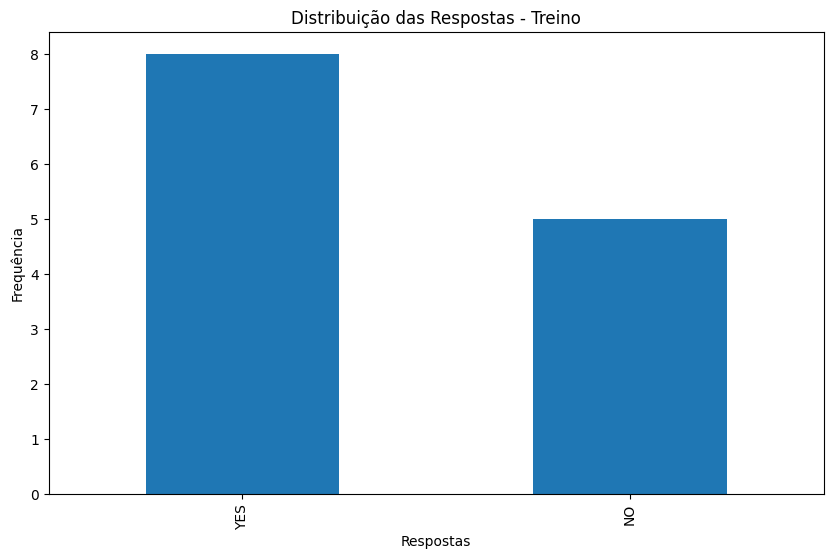


Analisando a distribuição das respostas:

answer
NO     29
YES    16
Name: count, dtype: int64


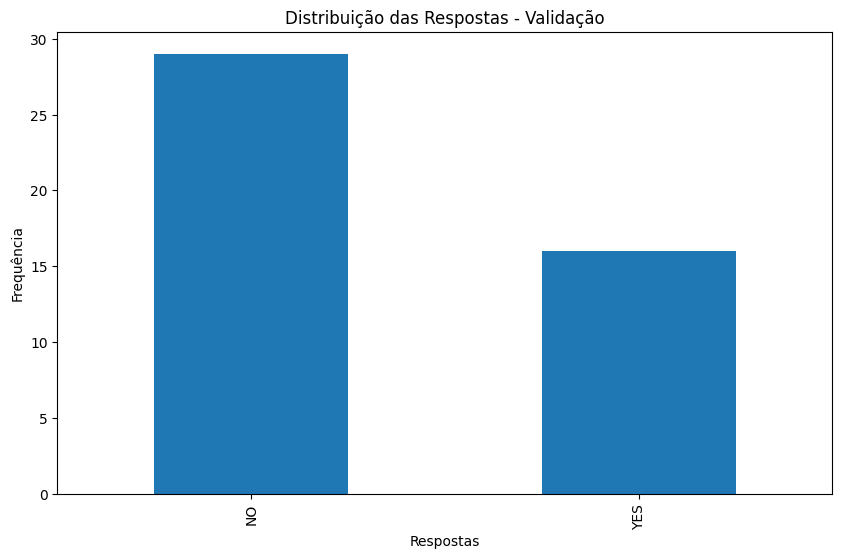

In [15]:
# Visualizar a distribuição das respostas
analyze_answers(train_data, title="Distribuição das Respostas - Treino")
analyze_answers(dev_data, title="Distribuição das Respostas - Validação")